In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import re

p2x_genes = ['P2RX1', 'P2RX2', 'P2RX3', 'P2RX4', 'P2RX5', 'P2RX6', 'P2RX7']

# Define the function to extract dataset ID
def extract_dataset_id(cell_name):
    match = re.search(r'_([^_]+)_p2x_filtered$', cell_name)
    return match.group(1) if match else None

# Define the function to extract sample ID
def extract_sample_id(cell_name):
    return re.sub(r'_[^_]+_p2x_filtered$', '', cell_name)

# Load the data
filtered_df = pd.read_csv('filtered_final_count_matrix.csv')
metadata = pd.read_csv('combined_metadata.csv')

# Set a minimum expression threshold (e.g., 1.0)
min_expression = 3.0

# Create binary expression matrix
binary_df = filtered_df.iloc[:, 1:].applymap(lambda x: 1 if x >= min_expression else 0)

# 1. Statistics on gene expression
def print_expression_stats(binary_df):
    single_gene_stats = binary_df.mean() * 100
    print("Percentage of cells expressing each gene:")
    print(single_gene_stats)
    
    pair_stats = (binary_df.sum(axis=1) == 2).mean() * 100
    print(f"\nPercentage of cells expressing 2 P2X genes: {pair_stats:.2f}%")
    
    triplet_stats = (binary_df.sum(axis=1) == 3).mean() * 100
    print(f"Percentage of cells expressing 3 P2X genes: {triplet_stats:.2f}%")
        
    triplet_stats = (binary_df.sum(axis=1) == 4).mean() * 100
    print(f"Percentage of cells expressing 4 P2X genes: {triplet_stats:.2f}%")

    triplet_stats = (binary_df.sum(axis=1) == 5).mean() * 100
    print(f"Percentage of cells expressing 5 P2X genes: {triplet_stats:.2f}%")

print_expression_stats(binary_df)

/local/bmsas1/ipykernel_4087157/4072422587.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_df = filtered_df.iloc[:, 1:].applymap(lambda x: 1 if x >= min_expression else 0)


Percentage of cells expressing each gene:
P2RX1     8.422166
P2RX2     0.754111
P2RX3     0.924531
P2RX4    27.123216
P2RX5     8.558170
P2RX6    10.398977
P2RX7    62.340872
dtype: float64

Percentage of cells expressing 2 P2X genes: 14.11%
Percentage of cells expressing 3 P2X genes: 2.06%
Percentage of cells expressing 4 P2X genes: 0.09%
Percentage of cells expressing 5 P2X genes: 0.00%


In [2]:
num_cells = len(filtered_df) - 1
print(f"Total number of cells: {num_cells}")

Total number of cells: 1502166


In [3]:
gene_counts = binary_df.sum(axis=1)
counts = gene_counts.value_counts().sort_index()
percentages = (counts / num_cells) * 100

for i in range(1, 8):
    count = counts.get(i, 0)
    percentage = percentages.get(i, 0)
    print(f"Cells expressing {i} P2X gene(s): {count} ({percentage:.2f}%)")

Cells expressing 1 P2X gene(s): 1257810 (83.73%)
Cells expressing 2 P2X gene(s): 211978 (14.11%)
Cells expressing 3 P2X gene(s): 30926 (2.06%)
Cells expressing 4 P2X gene(s): 1410 (0.09%)
Cells expressing 5 P2X gene(s): 43 (0.00%)
Cells expressing 6 P2X gene(s): 0 (0.00%)
Cells expressing 7 P2X gene(s): 0 (0.00%)


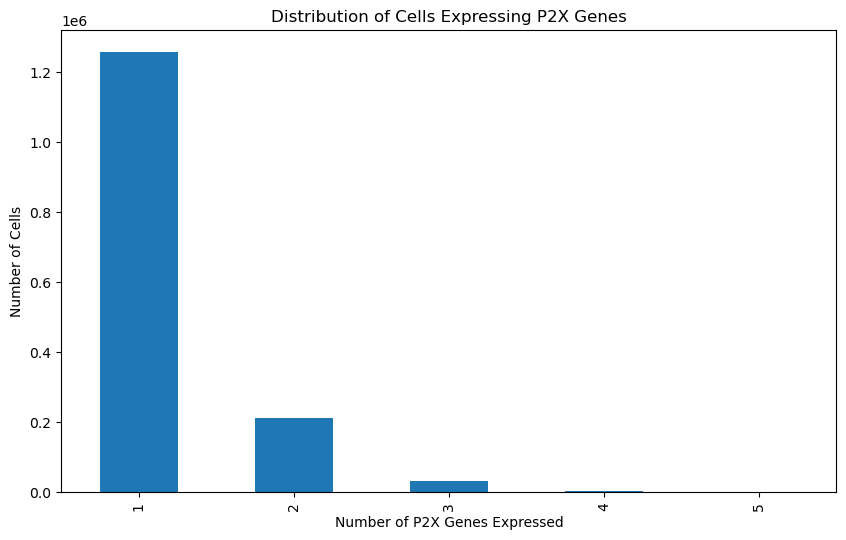

In [4]:
# Bar plot
plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.title('Distribution of Cells Expressing P2X Genes')
plt.xlabel('Number of P2X Genes Expressed')
plt.ylabel('Number of Cells')
plt.show()

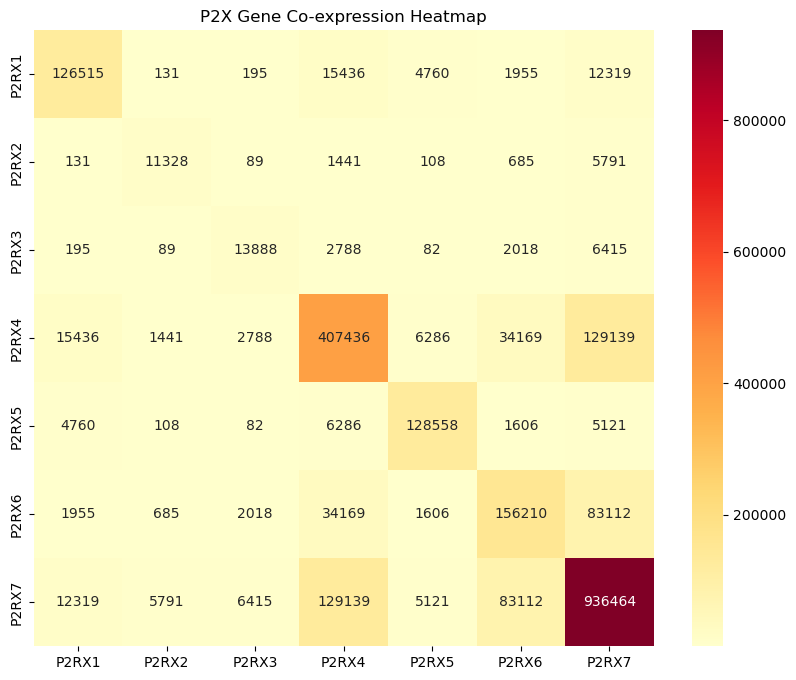

In [5]:
co_expression = binary_df.T.dot(binary_df)
plt.figure(figsize=(10, 8))
sns.heatmap(co_expression, annot=True, cmap='YlOrRd', fmt='.0f')
plt.title('P2X Gene Co-expression Heatmap')
plt.show()

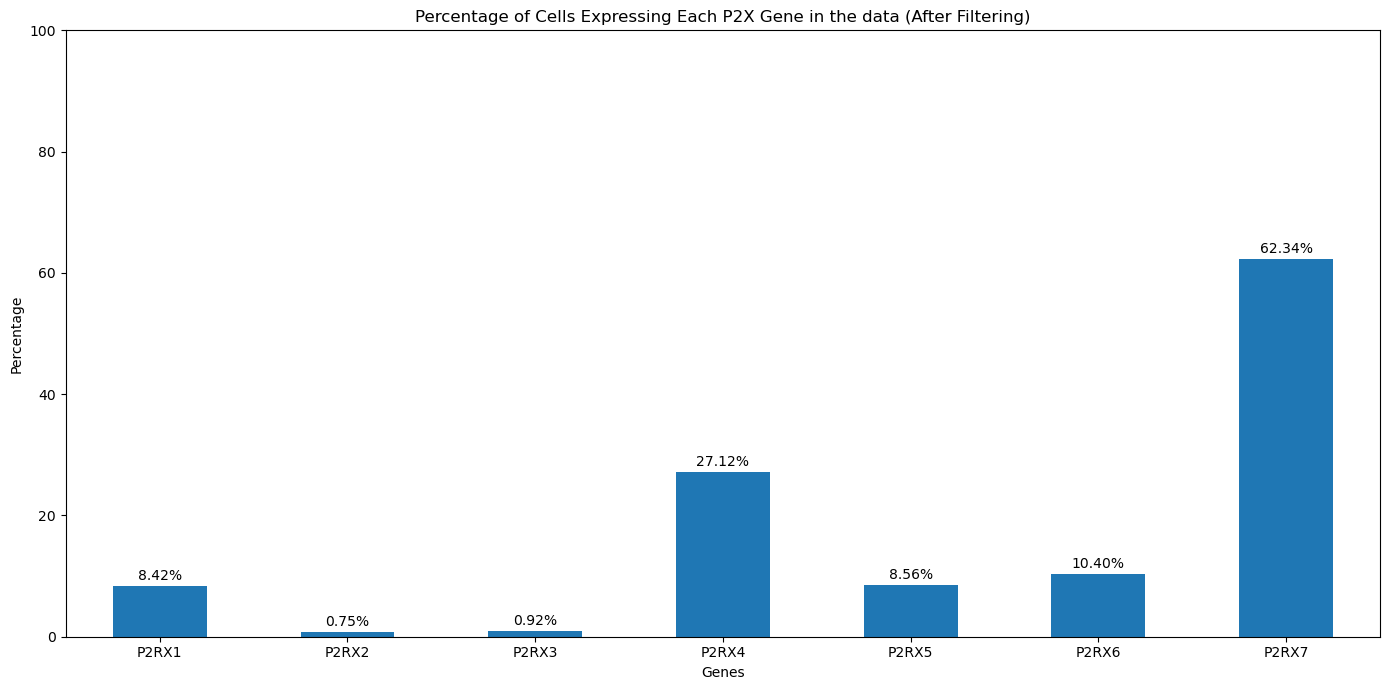

In [6]:
# Assuming merged_df is already created and contains the necessary data

# Calculate the percentage of non-zero for each gene
non_zero_expression = (filtered_df[p2x_genes] > 0).sum() / len(filtered_df) * 100

# Plot the percentage of non-zero expression
plt.figure(figsize=(14, 7))
non_zero_expression.plot(kind='bar')
plt.title('Percentage of Cells Expressing Each P2X Gene in the data (After Filtering)')
plt.xlabel('Genes')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100%

# Add percentage labels on top of each bar
for i, v in enumerate(non_zero_expression):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('p2x_gene_expression_percentage.png', dpi=300, bbox_inches='tight')

plt.show()

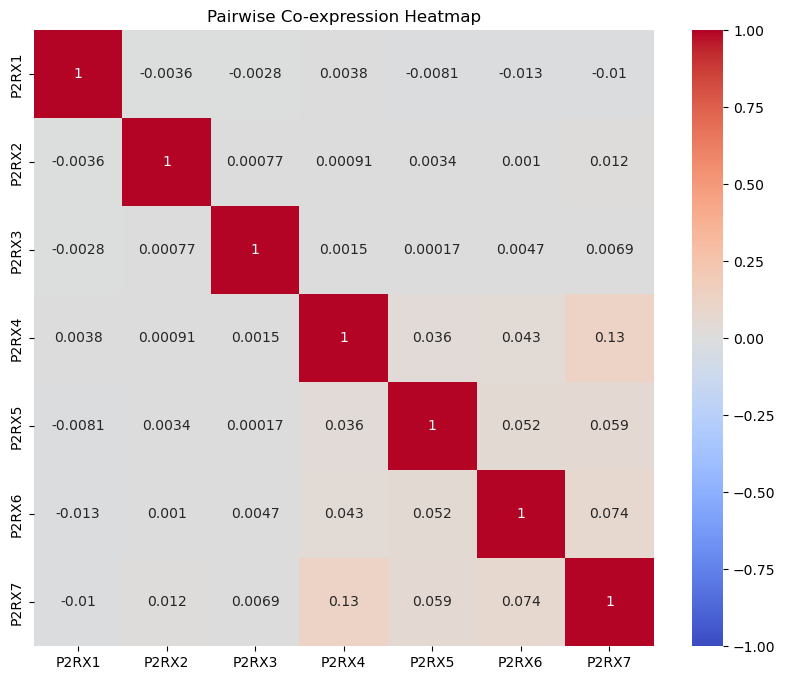

In [7]:
# 2. Pairwise Co-expression Analysis
def pairwise_coexpression(df):
    corr_matrix = df.corr(method='pearson')
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Pairwise Co-expression Heatmap')
    plt.show()

pairwise_coexpression(filtered_df.iloc[:, 1:])

In [8]:
filtered_df.iloc[:, 1:].head()

,P2RX1,P2RX2,P2RX3,P2RX4,P2RX5,P2RX6,P2RX7
0,0.0,0.0,NaN,3.123049,0.000000,0.0,0.000000
1,0.0,0.0,NaN,0.000000,3.053134,0.0,0.000000
2,0.0,0.0,0.0,3.193438,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.0,3.978093
4,0.0,0.0,0.0,3.077393,0.000000,0.0,0.000000


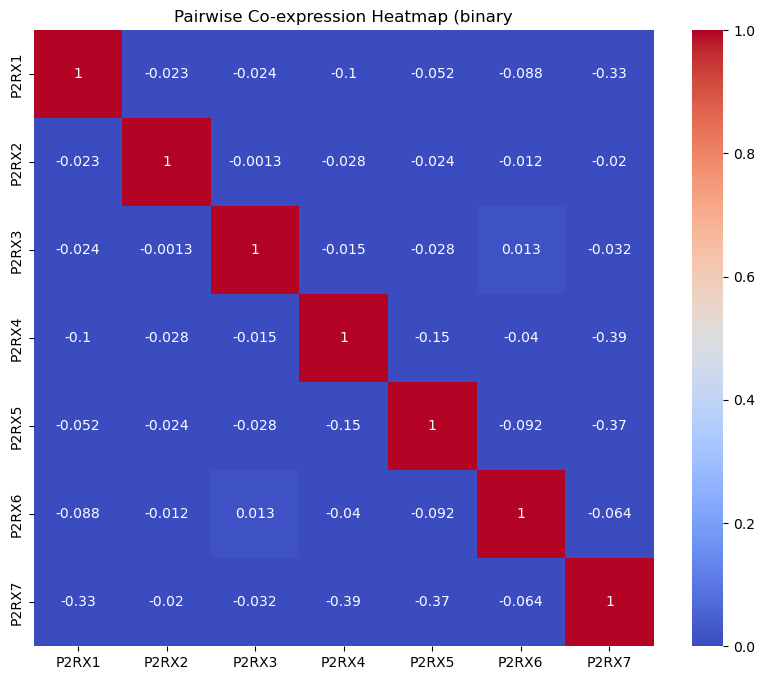

In [9]:
# Calculate pairwise co-expression
coexpression_matrix = binary_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(coexpression_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Pairwise Co-expression Heatmap (binary')
plt.show()

In [10]:
print(binary_df.head(20))

    P2RX1  P2RX2  P2RX3  P2RX4  P2RX5  P2RX6  P2RX7
0       0      0      0      1      0      0      0
1       0      0      0      0      1      0      0
2       0      0      0      1      0      0      0
3       0      0      0      0      0      0      1
4       0      0      0      1      0      0      0
5       0      0      0      0      0      0      1
6       0      0      1      0      0      0      0
7       0      0      0      0      0      0      1
8       0      0      0      1      0      0      0
9       0      0      0      1      0      0      0
10      0      0      0      0      0      0      1
11      0      0      0      1      0      0      0
12      0      0      0      0      0      0      1
13      0      0      0      1      0      0      0
14      1      0      0      0      0      0      0
15      0      0      0      0      0      1      0
16      0      0      0      0      0      0      1
17      0      0      0      1      0      0      0
18      0   

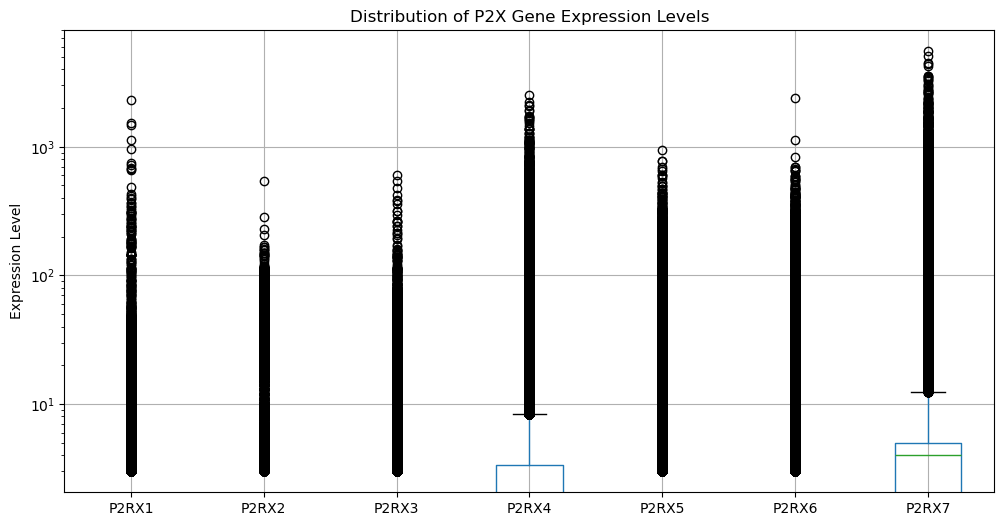

In [11]:

# Extract sample IDs from cell names in the filtered count matrix
filtered_df['sample_id'] = filtered_df.iloc[:, 0].apply(extract_sample_id)

plt.figure(figsize=(12, 6))
filtered_df[p2x_genes].boxplot()
plt.title('Distribution of P2X Gene Expression Levels')
plt.ylabel('Expression Level')
plt.yscale('log')
plt.show()

In [12]:
import numpy as np
from scipy import stats

# Merge filtered count matrix with metadata
merged_df = pd.merge(filtered_df, metadata, left_on='sample_id', right_on='sample', how='left')

# Define significance thresholds
CORRELATION_THRESHOLD = 0.15
MIN_CELL_COUNT = 1000

# Set this to True to include only positive correlations, False to include both positive and negative
POSITIVE_ONLY = True  # Change this to False if you want to include negative correlations

def analyze_coexpression_by_cell_type():
    significant_results = []

    # Group by cell type
    for cell_type, group in merged_df.groupby('cell_type'):
        if len(group) < MIN_CELL_COUNT:
            continue

        # Calculate correlations for each gene pair
        for i, gene1 in enumerate(p2x_genes):
            for gene2 in p2x_genes[i+1:]:
                # Remove rows with NaN or inf values
                valid_data = group[[gene1, gene2]].replace([np.inf, -np.inf], np.nan).dropna()
                
                if len(valid_data) < MIN_CELL_COUNT:
                    continue

                # Check if either gene has constant values
                if valid_data[gene1].nunique() == 1 or valid_data[gene2].nunique() == 1:
                    continue

                try:
                    corr, p_value = stats.pearsonr(valid_data[gene1], valid_data[gene2])
                except ValueError:
                    # This catches any other unexpected ValueError
                    continue
                
                # Check if correlation meets the threshold criteria
                if POSITIVE_ONLY:
                    if corr >= CORRELATION_THRESHOLD:
                        significant_results.append({
                            'cell_type': cell_type,
                            'gene1': gene1,
                            'gene2': gene2,
                            'correlation': corr,
                            'p_value': p_value,
                            'cell_count': len(valid_data)
                        })
                else:
                    if abs(corr) >= CORRELATION_THRESHOLD:
                        significant_results.append({
                            'cell_type': cell_type,
                            'gene1': gene1,
                            'gene2': gene2,
                            'correlation': corr,
                            'p_value': p_value,
                            'cell_count': len(valid_data)
                        })

    # Sort results by correlation value (descending order for positive correlations)
    significant_results.sort(key=lambda x: x['correlation'], reverse=True)

    # Print significant results
    for result in significant_results:
        print(f"Cell Type: {result['cell_type']}")
        print(f"Genes: {result['gene1']} and {result['gene2']}")
        print(f"Correlation: {result['correlation']:.4f}")
        print(f"P-value: {result['p_value']:.4e}")
        print(f"Cell Count: {result['cell_count']}")
        print("---")

# Run the analysis
analyze_coexpression_by_cell_type()

Cell Type: L6b glutamatergic cortical neuron
Genes: P2RX5 and P2RX7
Correlation: 0.2968
P-value: 3.7367e-268
Cell Count: 13276
---
Cell Type: L5 extratelencephalic projecting glutamatergic cortical neuron
Genes: P2RX5 and P2RX7
Correlation: 0.2236
P-value: 5.6463e-56
Cell Count: 4845
---
Cell Type: microglial cell
Genes: P2RX4 and P2RX7
Correlation: 0.1951
P-value: 1.5370e-78
Cell Count: 9069
---
Cell Type: epithelial cell
Genes: P2RX3 and P2RX6
Correlation: 0.1884
P-value: 1.1436e-37
Cell Count: 4554
---
Cell Type: near-projecting glutamatergic cortical neuron
Genes: P2RX5 and P2RX6
Correlation: 0.1860
P-value: 3.5126e-47
Cell Count: 5911
---
Cell Type: near-projecting glutamatergic cortical neuron
Genes: P2RX3 and P2RX6
Correlation: 0.1759
P-value: 8.6754e-47
Cell Count: 6567
---
Cell Type: L6b glutamatergic cortical neuron
Genes: P2RX4 and P2RX7
Correlation: 0.1652
P-value: 5.2687e-87
Cell Count: 14129
---
Cell Type: pvalb GABAergic cortical interneuron
Genes: P2RX6 and P2RX7
Correl

In [13]:
import numpy as np
from scipy import stats
import itertools

# Merge filtered count matrix with metadata
merged_df = pd.merge(filtered_df, metadata, left_on='sample_id', right_on='sample', how='left')

# Define significance thresholds
CORRELATION_THRESHOLD = 0.10
MIN_CELL_COUNT = 1000

# Set this to True to include only positive correlations, False to include both positive and negative
POSITIVE_ONLY = True  # Change this to False if you want to include negative correlations

def analyze_three_gene_coexpression():
    significant_results = []

    # Group by cell type
    for cell_type, group in merged_df.groupby('cell_type'):
        if len(group) < MIN_CELL_COUNT:
            continue

        # Calculate correlations for each trio of genes
        for gene1, gene2, gene3 in itertools.combinations(p2x_genes, 3):
            # Remove rows with NaN or inf values
            valid_data = group[[gene1, gene2, gene3]].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(valid_data) < MIN_CELL_COUNT:
                continue

            # Check if any gene has constant values
            if valid_data[gene1].nunique() == 1 or valid_data[gene2].nunique() == 1 or valid_data[gene3].nunique() == 1:
                continue

            try:
                # Calculate pairwise correlations
                corr12, _ = stats.pearsonr(valid_data[gene1], valid_data[gene2])
                corr13, _ = stats.pearsonr(valid_data[gene1], valid_data[gene3])
                corr23, _ = stats.pearsonr(valid_data[gene2], valid_data[gene3])

                # Calculate average correlation
                avg_corr = (corr12 + corr13 + corr23) / 3

                # Check if correlation meets the threshold criteria
                if POSITIVE_ONLY:
                    if avg_corr >= CORRELATION_THRESHOLD:
                        significant_results.append({
                            'cell_type': cell_type,
                            'genes': (gene1, gene2, gene3),
                            'average_correlation': avg_corr,
                            'cell_count': len(valid_data)
                        })
                else:
                    if abs(avg_corr) >= CORRELATION_THRESHOLD:
                        significant_results.append({
                            'cell_type': cell_type,
                            'genes': (gene1, gene2, gene3),
                            'average_correlation': avg_corr,
                            'cell_count': len(valid_data)
                        })

            except ValueError:
                # This catches any unexpected ValueError
                continue

    # Sort results by average correlation value (descending order for positive correlations)
    significant_results.sort(key=lambda x: x['average_correlation'], reverse=True)

    # Print significant results
    for result in significant_results:
        print(f"Cell Type: {result['cell_type']}")
        print(f"Genes: {', '.join(result['genes'])}")
        print(f"Average Correlation: {result['average_correlation']:.4f}")
        print(f"Cell Count: {result['cell_count']}")
        print("---")

# Run the analysis
analyze_three_gene_coexpression()

Cell Type: L6b glutamatergic cortical neuron
Genes: P2RX4, P2RX5, P2RX7
Average Correlation: 0.2054
Cell Count: 12898
---
Cell Type: L6b glutamatergic cortical neuron
Genes: P2RX5, P2RX6, P2RX7
Average Correlation: 0.1744
Cell Count: 13132
---
Cell Type: L5 extratelencephalic projecting glutamatergic cortical neuron
Genes: P2RX4, P2RX5, P2RX7
Average Correlation: 0.1369
Cell Count: 4501
---
Cell Type: L6b glutamatergic cortical neuron
Genes: P2RX1, P2RX5, P2RX7
Average Correlation: 0.1363
Cell Count: 13199
---
Cell Type: microglial cell
Genes: P2RX4, P2RX5, P2RX7
Average Correlation: 0.1343
Cell Count: 8007
---
Cell Type: near-projecting glutamatergic cortical neuron
Genes: P2RX5, P2RX6, P2RX7
Average Correlation: 0.1246
Cell Count: 5839
---
Cell Type: near-projecting glutamatergic cortical neuron
Genes: P2RX3, P2RX5, P2RX6
Average Correlation: 0.1232
Cell Count: 5882
---
Cell Type: L6b glutamatergic cortical neuron
Genes: P2RX4, P2RX6, P2RX7
Average Correlation: 0.1208
Cell Count: 140

In [14]:
'''
# Merge metadata with filtered data
merged_df = pd.merge(filtered_df, metadata, left_on='sample_id', right_on='sample')


#
def calculate_pairwise_correlation(df, genes):
    correlations = []
    for i, gene1 in enumerate(genes):
        for gene2 in genes[i+1:]:
            # Check if either array is constant
            if df[gene1].nunique() == 1 or df[gene2].nunique() == 1:
                corr = np.nan
            else:
                corr, _ = stats.spearmanr(df[gene1], df[gene2])
            correlations.append((gene1, gene2, corr))
    return correlations

print("Cell Type Co-expression Analysis:")

# 
cell_types_with_correlations = 0
correlation_threshold = 0.005  # Define threshold for significant correlation
min_cell_count = 100  # Minimum number of cells required for a cell type to be considered

# To include negative correlations, change this to `if not np.isnan(corr) and abs(corr) >= correlation_threshold`
correlation_filter = lambda corr: not np.isnan(corr) and corr >= correlation_threshold

for cell_type in merged_df['cell_type'].unique():
    # Create a dataframe for the current cell type
    cell_type_df = merged_df[merged_df['cell_type'] == cell_type]
    
    # Skip this cell type if it has fewer than min_cell_count cells
    if len(cell_type_df) < min_cell_count:
        continue
    
    # Calculate pairwise co-expression
    correlations = calculate_pairwise_correlation(cell_type_df[p2x_genes], p2x_genes)
    
    # Filter significant correlations
    significant_correlations = [
        (gene1, gene2, corr) 
        for gene1, gene2, corr in correlations 
        if correlation_filter(corr)
    ]
    
    # Print results if there are significant correlations
    if significant_correlations:
        cell_types_with_correlations += 1
        print(f"\nSignificant Correlations in Cell Type {cell_type}:")
        print(f"{'Gene1':<10} {'Gene2':<10} {'Correlation':<12}")
        print("-" * 40)
        for gene1, gene2, corr in significant_correlations:
            print(f"{gene1:<10} {gene2:<10} {corr:<12.4f}")
        
        # Print total number of cells for this cell type
        total_cells = len(cell_type_df)
        print(f"Total number of cells for {cell_type}: {total_cells}")

# Print summary
print(f"\nTotal number of cell types with significant correlations: {cell_types_with_correlations}")

# To change the minimum cell count, modify the `min_cell_count` variable at the top of the script
'''

'\n# Merge metadata with filtered data\nmerged_df = pd.merge(filtered_df, metadata, left_on=\'sample_id\', right_on=\'sample\')\n\n\n#\ndef calculate_pairwise_correlation(df, genes):\n    correlations = []\n    for i, gene1 in enumerate(genes):\n        for gene2 in genes[i+1:]:\n            # Check if either array is constant\n            if df[gene1].nunique() == 1 or df[gene2].nunique() == 1:\n                corr = np.nan\n            else:\n                corr, _ = stats.spearmanr(df[gene1], df[gene2])\n            correlations.append((gene1, gene2, corr))\n    return correlations\n\nprint("Cell Type Co-expression Analysis:")\n\n# \ncell_types_with_correlations = 0\ncorrelation_threshold = 0.005  # Define threshold for significant correlation\nmin_cell_count = 100  # Minimum number of cells required for a cell type to be considered\n\n# To include negative correlations, change this to `if not np.isnan(corr) and abs(corr) >= correlation_threshold`\ncorrelation_filter = lambda corr

In [15]:
# Function to identify top potential heterotrimers
def identify_top_heterotrimers(df, genes):
    combinations = []
    for i, gene1 in enumerate(genes):
        for j, gene2 in enumerate(genes[i+1:], start=i+1):
            for gene3 in genes[j+1:]:
                mask = (df[gene1] > 0) & (df[gene2] > 0) & (df[gene3] > 0)
                coexpression = mask.sum() / len(df) * 100
                combinations.append((gene1, gene2, gene3, coexpression))
    
    combinations.sort(key=lambda x: x[3], reverse=True)
    print("\nTop 10 potential heterotrimers:")
    for combo in combinations[:20]:
        print(f"{combo[0]}-{combo[1]}-{combo[2]}: {combo[3]:.2f}% co-expression")

# Identify top potential heterotrimers
identify_top_heterotrimers(merged_df[p2x_genes], p2x_genes)


Top 10 potential heterotrimers:
P2RX4-P2RX6-P2RX7: 1.47% co-expression
P2RX1-P2RX4-P2RX7: 0.23% co-expression
P2RX3-P2RX4-P2RX7: 0.12% co-expression
P2RX3-P2RX6-P2RX7: 0.09% co-expression
P2RX4-P2RX5-P2RX7: 0.09% co-expression
P2RX1-P2RX6-P2RX7: 0.08% co-expression
P2RX2-P2RX4-P2RX7: 0.08% co-expression
P2RX5-P2RX6-P2RX7: 0.06% co-expression
P2RX3-P2RX4-P2RX6: 0.04% co-expression
P2RX1-P2RX4-P2RX5: 0.04% co-expression
P2RX2-P2RX6-P2RX7: 0.04% co-expression
P2RX1-P2RX4-P2RX6: 0.03% co-expression
P2RX4-P2RX5-P2RX6: 0.03% co-expression
P2RX2-P2RX4-P2RX6: 0.02% co-expression
P2RX1-P2RX5-P2RX7: 0.01% co-expression
P2RX1-P2RX3-P2RX7: 0.01% co-expression
P2RX2-P2RX5-P2RX7: 0.01% co-expression
P2RX2-P2RX3-P2RX7: 0.01% co-expression
P2RX1-P2RX3-P2RX4: 0.00% co-expression
P2RX1-P2RX3-P2RX6: 0.00% co-expression


In [16]:
'''
# First, add the dataset information to the merged_df
merged_df['dataset'] = merged_df.iloc[:, 0].apply(extract_dataset_id)

print("Dataset Co-expression Analysis:")

datasets_with_correlations = 0
correlation_threshold = 0.001  # Define threshold for significant correlation
min_cell_count = 1  # Minimum number of cells required for a dataset to be considered

# To include negative correlations, change this to `if not np.isnan(corr) and abs(corr) >= correlation_threshold`
correlation_filter = lambda corr: not np.isnan(corr) and corr >= correlation_threshold

for dataset in merged_df['dataset'].unique():
    # Create a dataframe for the current dataset
    dataset_df = merged_df[merged_df['dataset'] == dataset]
    
    # Skip this dataset if it has fewer than min_cell_count cells
    if len(dataset_df) < min_cell_count:
        continue
    
    # Calculate pairwise co-expression
    correlations = calculate_pairwise_correlation(dataset_df[p2x_genes], p2x_genes)
    
    # Filter significant correlations
    significant_correlations = [
        (gene1, gene2, corr)
        for gene1, gene2, corr in correlations
        if correlation_filter(corr)
    ]
    
    # Print results if there are significant correlations
    if significant_correlations:
        datasets_with_correlations += 1
        print(f"\nSignificant Correlations in Dataset {dataset}:")
        print(f"{'Gene1':<10} {'Gene2':<10} {'Correlation':<12}")
        print("-" * 40)
        for gene1, gene2, corr in significant_correlations:
            print(f"{gene1:<10} {gene2:<10} {corr:<12.4f}")
    
    # Print total number of cells for this dataset
    total_cells = len(dataset_df)
    print(f"Total number of cells for {dataset}: {total_cells}")

# Print summary
print(f"\nTotal number of datasets with significant correlations: {datasets_with_correlations}")
'''

'\n# First, add the dataset information to the merged_df\nmerged_df[\'dataset\'] = merged_df.iloc[:, 0].apply(extract_dataset_id)\n\nprint("Dataset Co-expression Analysis:")\n\ndatasets_with_correlations = 0\ncorrelation_threshold = 0.001  # Define threshold for significant correlation\nmin_cell_count = 1  # Minimum number of cells required for a dataset to be considered\n\n# To include negative correlations, change this to `if not np.isnan(corr) and abs(corr) >= correlation_threshold`\ncorrelation_filter = lambda corr: not np.isnan(corr) and corr >= correlation_threshold\n\nfor dataset in merged_df[\'dataset\'].unique():\n    # Create a dataframe for the current dataset\n    dataset_df = merged_df[merged_df[\'dataset\'] == dataset]\n    \n    # Skip this dataset if it has fewer than min_cell_count cells\n    if len(dataset_df) < min_cell_count:\n        continue\n    \n    # Calculate pairwise co-expression\n    correlations = calculate_pairwise_correlation(dataset_df[p2x_genes], p2x_

In [17]:
'''
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set a threshold for grouping into "Others" (e.g., 5%)
others_threshold = 5

# Calculate the percentage of each cell type for each P2X gene
p2x_cell_type_percentages = {}
others_count = {}
for gene in p2x_genes:
    gene_expressed = merged_df[merged_df[gene] > 0]
    cell_type_counts = gene_expressed['cell_type'].value_counts()
    total_count = cell_type_counts.sum()
    percentages = (cell_type_counts / total_count * 100).sort_values(ascending=False)
    
    # Group small percentages into "Others"
    small_types = percentages[percentages < others_threshold]
    others = small_types.sum()
    main_types = percentages[percentages >= others_threshold]
    if others > 0:
        main_types['Others'] = others
        others_count[gene] = len(small_types)
    
    p2x_cell_type_percentages[gene] = main_types

# Get all unique cell types (including "Others")
all_cell_types = set()
for percentages in p2x_cell_type_percentages.values():
    all_cell_types.update(percentages.index)

# Create a custom color palette
colors = sns.color_palette("husl", len(all_cell_types) - 1)  # One less color because "Others" will be grey
color_dict = dict(zip([x for x in sorted(all_cell_types) if x != 'Others'], colors))
color_dict['Others'] = 'grey'  # Set "Others" to grey

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(15, 10))

bottom = np.zeros(7)
for cell_type in sorted(all_cell_types, key=lambda x: (x == 'Others', x)):  # Ensures 'Others' is last
    percentages = [p2x_cell_type_percentages[gene].get(cell_type, 0) for gene in p2x_genes]
    bars = ax.bar(p2x_genes, percentages, bottom=bottom, label=cell_type, color=color_dict[cell_type])
    
    # Add percentage labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            if cell_type == 'Others':
                label = f'Others\n({others_count[p2x_genes[i]]} other cell types)\n{height:.1f}%'
            else:
                label = f'{height:.1f}%'
            ax.text(bar.get_x() + bar.get_width()/2, bottom[i] + height/2,
                    label, ha='center', va='center', rotation='vertical', fontsize=12)
    
    bottom += percentages

ax.set_title('Percentage Distribution of Cell Types Expressing P2X Genes', fontsize=16)
ax.set_xlabel('P2X Genes', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_ylim(0, 100)
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust legend
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
for handle in legend.legendHandles:
    handle.set_edgecolor('black')
    handle.set_linewidth(0.5)

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('p2x_gene_expression_percentages.png', dpi=300, bbox_inches='tight')

# Show the plot (optional, you can comment this out if you don't want to display it)
plt.show()
'''

'\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport seaborn as sns\n\n# Set a threshold for grouping into "Others" (e.g., 5%)\nothers_threshold = 5\n\n# Calculate the percentage of each cell type for each P2X gene\np2x_cell_type_percentages = {}\nothers_count = {}\nfor gene in p2x_genes:\n    gene_expressed = merged_df[merged_df[gene] > 0]\n    cell_type_counts = gene_expressed[\'cell_type\'].value_counts()\n    total_count = cell_type_counts.sum()\n    percentages = (cell_type_counts / total_count * 100).sort_values(ascending=False)\n    \n    # Group small percentages into "Others"\n    small_types = percentages[percentages < others_threshold]\n    others = small_types.sum()\n    main_types = percentages[percentages >= others_threshold]\n    if others > 0:\n        main_types[\'Others\'] = others\n        others_count[gene] = len(small_types)\n    \n    p2x_cell_type_percentages[gene] = main_types\n\n# Get all unique cell types (including "Others")\nall_cell_types = set()\

In [18]:
import numpy as np
from scipy import stats
import itertools

# Merge filtered count matrix with metadata
merged_df = pd.merge(filtered_df, metadata, left_on='sample_id', right_on='sample', how='left')

# Define significance thresholds
CORRELATION_THRESHOLD = 0.1
MIN_CELL_COUNT = 100

# Set this to True to include only positive correlations, False to include both positive and negative
POSITIVE_ONLY = True  # Change this to False if you want to include negative correlations

def analyze_three_gene_coexpression():
    significant_results = []

    # Group by cell type
    for cell_type, group in merged_df.groupby('cell_type'):
        if len(group) < MIN_CELL_COUNT:
            continue

        # Calculate correlations for each trio of genes
        for gene1, gene2, gene3 in itertools.combinations(p2x_genes, 3):
            # Remove rows with NaN or inf values
            valid_data = group[[gene1, gene2, gene3]].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(valid_data) < MIN_CELL_COUNT:
                continue

            # Check if any gene has constant values
            if valid_data[gene1].nunique() == 1 or valid_data[gene2].nunique() == 1 or valid_data[gene3].nunique() == 1:
                continue

            try:
                # Calculate pairwise correlations
                corr12, _ = stats.pearsonr(valid_data[gene1], valid_data[gene2])
                corr13, _ = stats.pearsonr(valid_data[gene1], valid_data[gene3])
                corr23, _ = stats.pearsonr(valid_data[gene2], valid_data[gene3])

                # Use the minimum correlation as the measure of three-way relationship
                min_corr = min(corr12, corr13, corr23)

                # Check if correlation meets the threshold criteria
                if POSITIVE_ONLY:
                    if min_corr >= CORRELATION_THRESHOLD:
                        significant_results.append({
                            'cell_type': cell_type,
                            'genes': (gene1, gene2, gene3),
                            'min_correlation': min_corr,
                            'all_correlations': (corr12, corr13, corr23),
                            'cell_count': len(valid_data)
                        })
                else:
                    if abs(min_corr) >= CORRELATION_THRESHOLD:
                        significant_results.append({
                            'cell_type': cell_type,
                            'genes': (gene1, gene2, gene3),
                            'min_correlation': min_corr,
                            'all_correlations': (corr12, corr13, corr23),
                            'cell_count': len(valid_data)
                        })

            except ValueError:
                # This catches any unexpected ValueError
                continue

    # Sort results by minimum correlation value (descending order for positive correlations)
    significant_results.sort(key=lambda x: x['min_correlation'], reverse=True)

    # Print significant results
    for result in significant_results:
        print(f"Cell Type: {result['cell_type']}")
        print(f"Genes: {', '.join(result['genes'])}")
        print(f"Minimum Correlation: {result['min_correlation']:.4f}")
        print(f"All Correlations: {', '.join([f'{c:.4f}' for c in result['all_correlations']])}")
        print(f"Cell Count: {result['cell_count']}")
        print("---")

# Run the analysis
analyze_three_gene_coexpression()

Cell Type: L6b glutamatergic cortical neuron
Genes: P2RX4, P2RX5, P2RX7
Minimum Correlation: 0.1469
All Correlations: 0.1469, 0.1642, 0.3051
Cell Count: 12898
---


In [19]:
#binary:

In [22]:
import numpy as np
from scipy import stats
import re

# Define the function to extract sample ID
def extract_sample_id(cell_name):
    return re.sub(r'_[^_]+_p2x_filtered$', '', cell_name)

# Add sample_id to binary_df
binary_df['sample_id'] = binary_df.index.map(extract_sample_id)

# Merge binary df with metadata
merged_df = pd.merge(binary_df, metadata, left_on='sample_id', right_on='sample', how='left')

# Define significance thresholds
CORRELATION_THRESHOLD = 0.05
MIN_CELL_COUNT = 100

# Set this to True to include only positive correlations, False to include both positive and negative
POSITIVE_ONLY = True  # Change this to False if you want to include negative correlations

def analyze_coexpression_by_cell_type():
    significant_results = []

    # Group by cell type
    for cell_type, group in merged_df.groupby('cell_type'):
        if len(group) < MIN_CELL_COUNT:
            continue

        # Calculate correlations for each gene pair
        for i, gene1 in enumerate(p2x_genes):
            for gene2 in p2x_genes[i+1:]:
                # No need to remove NaN or inf values as binary_df should only contain 0 and 1
                valid_data = group[[gene1, gene2]]
                
                if len(valid_data) < MIN_CELL_COUNT:
                    continue

                # Check if either gene has constant values
                if valid_data[gene1].nunique() == 1 or valid_data[gene2].nunique() == 1:
                    continue

                try:
                    # Use phi coefficient (equivalent to Pearson correlation for binary data)
                    contingency_table = pd.crosstab(valid_data[gene1], valid_data[gene2])
                    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
                    corr = np.sqrt(chi2 / (len(valid_data) * min(contingency_table.shape)))
                    if contingency_table.iloc[0, 0] * contingency_table.iloc[1, 1] < contingency_table.iloc[0, 1] * contingency_table.iloc[1, 0]:
                        corr = -corr
                except ValueError:
                    # This catches any unexpected ValueError
                    continue
                
                # Check if correlation meets the threshold criteria
                if POSITIVE_ONLY:
                    if corr >= CORRELATION_THRESHOLD:
                        significant_results.append({
                            'cell_type': cell_type,
                            'gene1': gene1,
                            'gene2': gene2,
                            'correlation': corr,
                            'p_value': p_value,
                            'cell_count': len(valid_data)
                        })
                else:
                    if abs(corr) >= CORRELATION_THRESHOLD:
                        significant_results.append({
                            'cell_type': cell_type,
                            'gene1': gene1,
                            'gene2': gene2,
                            'correlation': corr,
                            'p_value': p_value,
                            'cell_count': len(valid_data)
                        })

    # Sort results by correlation value (descending order for positive correlations)
    significant_results.sort(key=lambda x: x['correlation'], reverse=True)

    # Print significant results
    for result in significant_results:
        print(f"Cell Type: {result['cell_type']}")
        print(f"Genes: {result['gene1']} and {result['gene2']}")
        print(f"Correlation: {result['correlation']:.4f}")
        print(f"P-value: {result['p_value']:.4e}")
        print(f"Cell Count: {result['cell_count']}")
        print("---")

# Run the analysis
analyze_coexpression_by_cell_type()